## Import:

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# !pip install shap

In [3]:
np.random.seed(42)
from LatentSHAP_image_classification import LatentExplainerImgs



C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load images:

In [4]:
# Load dataset
dsprites_numpy_path = "dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
dataset_zip = np.load(dsprites_numpy_path, allow_pickle=True, encoding = 'latin1')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

# print('Metadata: \n', metadata)
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x00000232CB8FA800>)


## Custom generator for batching data

In [5]:
def data_generator(images, latents_values, batch_size=32):
    num_samples = len(images)
    while True:
        indices = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = images[batch_indices]
            batch_images = batch_images.reshape(batch_images.shape[0], 64, 64, 1)


            batch_latents_values = latents_values[batch_indices]
            batch_latents_values = batch_latents_values.astype('float32')
            # Split the latent factors for individual losses
            batch_latents_color = batch_latents_values[:, 0]
            batch_latents_shape = batch_latents_values[:, 1]
            batch_latents_scale = batch_latents_values[:, 2]
            batch_latents_orientation = batch_latents_values[:, 3]
            batch_latents_x_position = batch_latents_values[:, 4]
            batch_latents_y_position = batch_latents_values[:, 5]
            yield batch_images, [batch_latents_color, batch_latents_shape, batch_latents_scale, batch_latents_orientation, batch_latents_x_position, batch_latents_y_position]

## Split to train/test

In [7]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_latents, test_latents = train_test_split(imgs, latents_values, test_size=0.01, random_state=17)
del imgs #remove imgs to save RAM 

test_color = test_latents[:, 0]
test_shape = test_latents[:, 1]
test_scale = test_latents[:, 2]
test_orientation = test_latents[:, 3]
test_x_position = test_latents[:, 4]
test_y_position = test_latents[:, 5]
test_images = test_images.reshape(test_images.shape[0], 64, 64, 1)

## Define tensorflow model 

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, utils
from sklearn.model_selection import train_test_split

# Define custom losses for each latent factor
def shape_loss(y_true, y_pred):
    # correct one based index
    y_true_zero_based = y_true-1
    return losses.sparse_categorical_crossentropy(y_true_zero_based, y_pred)

def latent_factors_model():
    inputs = layers.Input(shape=(64, 64, 1))

    # Your CNN model architecture
    # Example:
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)


    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    x = layers.Dense(128, activation='relu')(x)

    x = layers.Dense(64, activation='relu')(x)

    x = layers.Dense(32, activation='relu')(x)

    # Output layers for each latent factor
    color = layers.Dense(1, activation='sigmoid')(x)
    shape = layers.Dense(3, activation='softmax')(x)
    scale = layers.Dense(1, activation='linear')(x)
    x_position = layers.Dense(1, activation='linear')(x)
    y_position = layers.Dense(1, activation='linear')(x)
    orientation = layers.Dense(1, activation='linear')(x)

    # Combine all outputs into a single list
    outputs = [color, shape, scale, orientation, x_position, y_position]

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## Load pretrained weights

In [9]:
model = latent_factors_model()
model_saved_path = "dSprites_predict_latents.keras"
model.load_weights(model_saved_path)

## Setup classifier


In [11]:
#define prediction functions:
def model_to_be_explained(x): #rule-based classifier
    assert len(x.shape) in [3, 4] # assert if len(x.shape) is not 3/4 - the axis indices will change
    res = x.sum(axis=2)[:,:32] #summerize for each row, then take the 32 upper rows (the upper segment)
    res = res.sum(axis=1)>0 #set True for images with at least one pixel on the upper segment, False to the others
    return res * 1 #cast True/False to numeric 


def model_prediction_to_latent(raw_preds): #organize the model outputs
    latents = np.zeros((raw_preds[0].shape[0], 6))
    latents[:,0] = raw_preds[0][:,0]
    latents[:,1] = raw_preds[1].argmax(axis=1)
    latents[:,2] = raw_preds[2][:,0]
    latents[:,3] = raw_preds[3][:,0]
    latents[:,4] = raw_preds[4][:,0]
    latents[:,5] = raw_preds[5][:,0]
    return latents

# setup transformation function - use the model and organize the predictions
def transformation(z):
    raw_preds = model.predict(z, verbose=0)
    latents = model_prediction_to_latent(raw_preds)
    return latents

## Prepare data for explainability:

In [12]:
# #choose what images to explain and background size
img_to_explain = test_images[:10, :]
bg_data = train_images[:1000, :]
#choose latent surrogate model type
from sklearn.tree import DecisionTreeClassifier
proximity_model = DecisionTreeClassifier()

## Produce explanation for the image classifier:

In [13]:
explainer = LatentExplainerImgs(model=model_to_be_explained, transformation=transformation,
                                background_data=bg_data, proximity_model=proximity_model)

shap_values_proposed_method = explainer.latent_shap_values(img_to_explain)
latent_feature_names = metadata["latents_names"]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.91it/s]


## Global feature importance:

In [15]:
#use shap's vizualization
import shap
from shap._explanation import Explanation


In [23]:
base_val = np.array([explainer.expected_value])

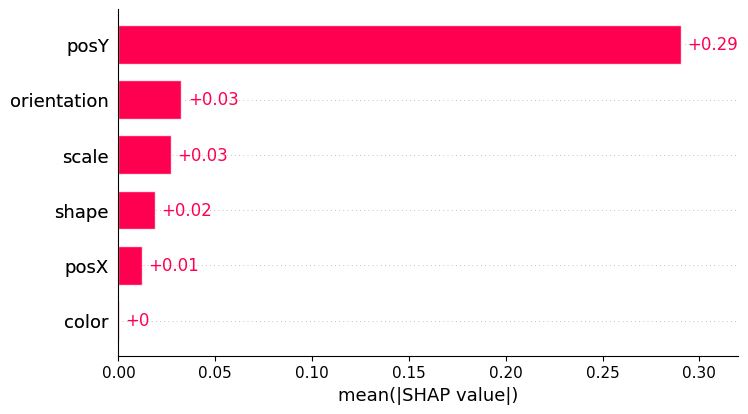

In [24]:
explanation_object_global = Explanation(values=shap_values_proposed_method[0],
                        base_values=base_val,
                        data = transformation(img_to_explain),
                        feature_names = latent_feature_names)
global_f = plt.gcf()
shap.plots.bar(explanation_object_global, show=False)


In [25]:
# name = f'global eplanation dsprite.pdf'
# # name = 'local explanation for first sample with all 39 features (bg size 150) knn'
# global_f.savefig(name, transparent=True, bbox_inches='tight', pad_inches=0) #'out.svg'

## Visualize positive and negative examples:

In [26]:
pred_10_test = model_to_be_explained(img_to_explain[:10])
ind_of_positive = np.argwhere(pred_10_test==1)[1,0]
ind_of_negative = np.argwhere(pred_10_test==0)[0,0] 

In [27]:
positive_img, negative_img = test_images[ind_of_positive], test_images[ind_of_negative]

positive

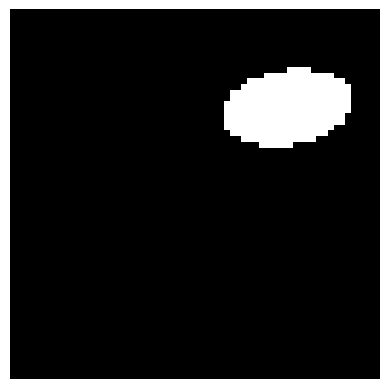

In [28]:
plt.imshow(positive_img, cmap='Greys_r')
name = f'positive_img.pdf'
plt.axis('off')
# plt.savefig(name, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

negative

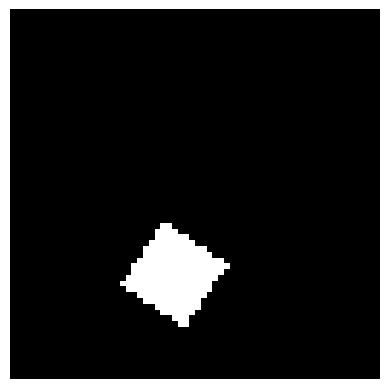

In [29]:
plt.imshow(negative_img, cmap='Greys_r')
name = f'negative_img.pdf'
plt.axis('off')
# plt.savefig(name, transparent=True, bbox_inches='tight', pad_inches=0) #'out.svg'
plt.show()

## Explain positive and negative examples:

positive

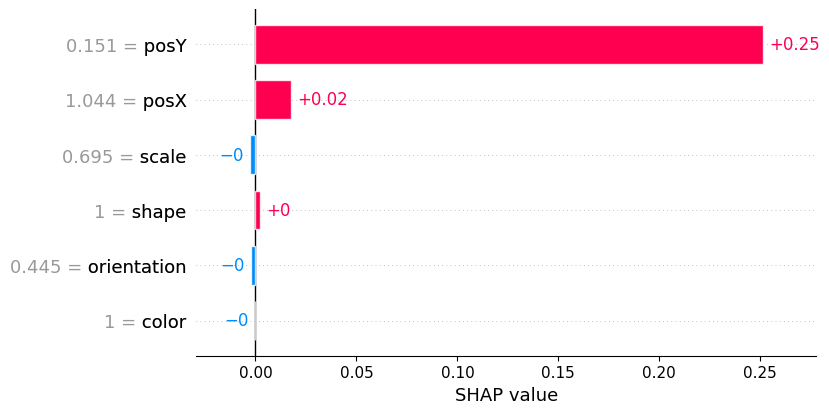

In [32]:
explanation_object_pos = Explanation(values=shap_values_proposed_method[0][ind_of_positive],
                        base_values=explainer.expected_value,
                        data = transformation(img_to_explain)[ind_of_positive],
                        feature_names = latent_feature_names)
f = plt.gcf()
shap.plots.bar(explanation_object_pos, show=False)


In [33]:
# name = f'local eplanation ind_of_positive force.pdf'
# # name = 'local explanation for first sample with all 39 features (bg size 150) knn'
# f.savefig(name, transparent=True, bbox_inches='tight', pad_inches=0) #'out.svg'

negativ

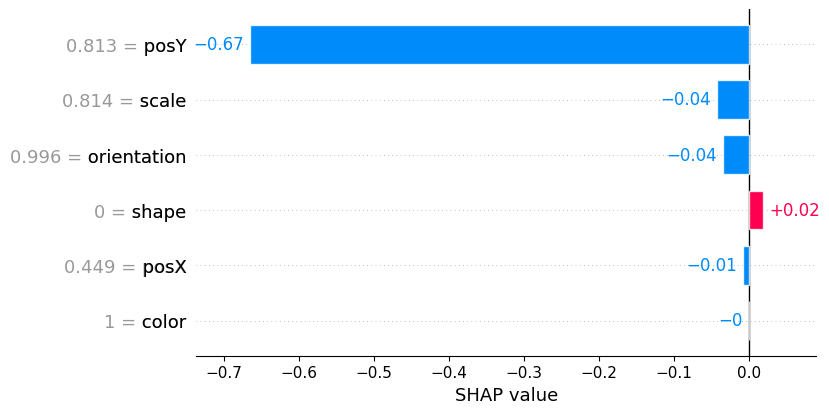

In [30]:
import shap
from shap._explanation import Explanation

explanation_object = Explanation(values=shap_values_proposed_method[0][ind_of_negative],
                        base_values=explainer.expected_value,
                        data = transformation(img_to_explain)[ind_of_negative],
                        feature_names = latent_feature_names)
fig = shap.plots.bar(explanation_object, show=False)

plt.show()

In [31]:
# name = f'local eplanation ind_of_negative force.pdf'
# # name = 'local explanation for first sample with all 39 features (bg size 150) knn'
# fig.savefig(name, transparent=True, bbox_inches='tight', pad_inches=0) #'out.svg'